# 1. **Imports**

In [65]:
from collections import Counter
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.decomposition import PCA, KernelPCA
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# 2. **Functions**

In [2]:
def extract_features(sensor_array):
    return pd.DataFrame({
        'mean': sensor_array.mean(axis=1),
        'std': sensor_array.std(axis=1),
        'min': sensor_array.min(axis=1),
        'max': sensor_array.max(axis=1),
        'median': sensor_array.median(axis=1)
    })

In [4]:
def plot_feature_correlations(df_list, feature_names):

    num_features = len(feature_names)

    for feature in feature_names:
        # Criar DataFrame com colunas: sensor1_{feature}, sensor2_{feature}, ...
        df_corr = pd.DataFrame({
            f'Sensor{i+1}': df_list[i][f'sensor{i+1}_{feature}']
            for i in range(len(df_list))
        })

        # Calcular correlação entre sensores
        sensor_corr = df_corr.corr()

        # Plot
        plt.figure(figsize=(6, 5))
        sns.heatmap(sensor_corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
        plt.title(f"Correlação entre Sensores ({feature})")
        plt.tight_layout()
        plt.show()

# 3. **Data Loading**

In [5]:
classes = np.load("Classes.npy", allow_pickle=True)
data1 = np.load("Dados_1.npy", allow_pickle=True)
data2 = np.load("Dados_2.npy", allow_pickle=True)
data3 = np.load("Dados_3.npy", allow_pickle=True)
data4 = np.load("Dados_4.npy", allow_pickle=True)
data5 = np.load("Dados_5.npy", allow_pickle=True)

In [6]:
label_df = pd.DataFrame(classes)
df1 = pd.DataFrame(data1)
df2 = pd.DataFrame(data2)
df3 = pd.DataFrame(data3)
df4 = pd.DataFrame(data4)
df5 = pd.DataFrame(data5)

 # **Classes**



In [7]:
label_df.head()

,0
0,Classe D
1,Classe A
2,Classe A
3,Classe B
4,Classe D


In [8]:
label_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       50000 non-null  object
dtypes: object(1)
memory usage: 390.8+ KB


In [9]:
label_df.shape

(50000, 1)

In [11]:
label_df.describe()

,0
count,50000
unique,5
top,Classe D
freq,10000


In [12]:
flat_classes = classes.flatten()
print(flat_classes)

['Classe D' 'Classe A' 'Classe A' ... 'Classe D' 'Classe A' 'Classe B']


In [13]:
freq_classes = Counter(flat_classes)
print(freq_classes)

Counter({'Classe D': 10000, 'Classe A': 10000, 'Classe B': 10000, 'Classe E': 10000, 'Classe C': 10000})


In [14]:
label_df.columns = ['label']

In [15]:
le = LabelEncoder()
label_df =  pd.DataFrame(le.fit_transform(label_df['label']))
label_df.columns = ['label']

In [16]:
label_df.head()

,label
0,3
1,0
2,0
3,1
4,3


# 4. **Sensor behavior**

Text(0.5, 0, 'Time')

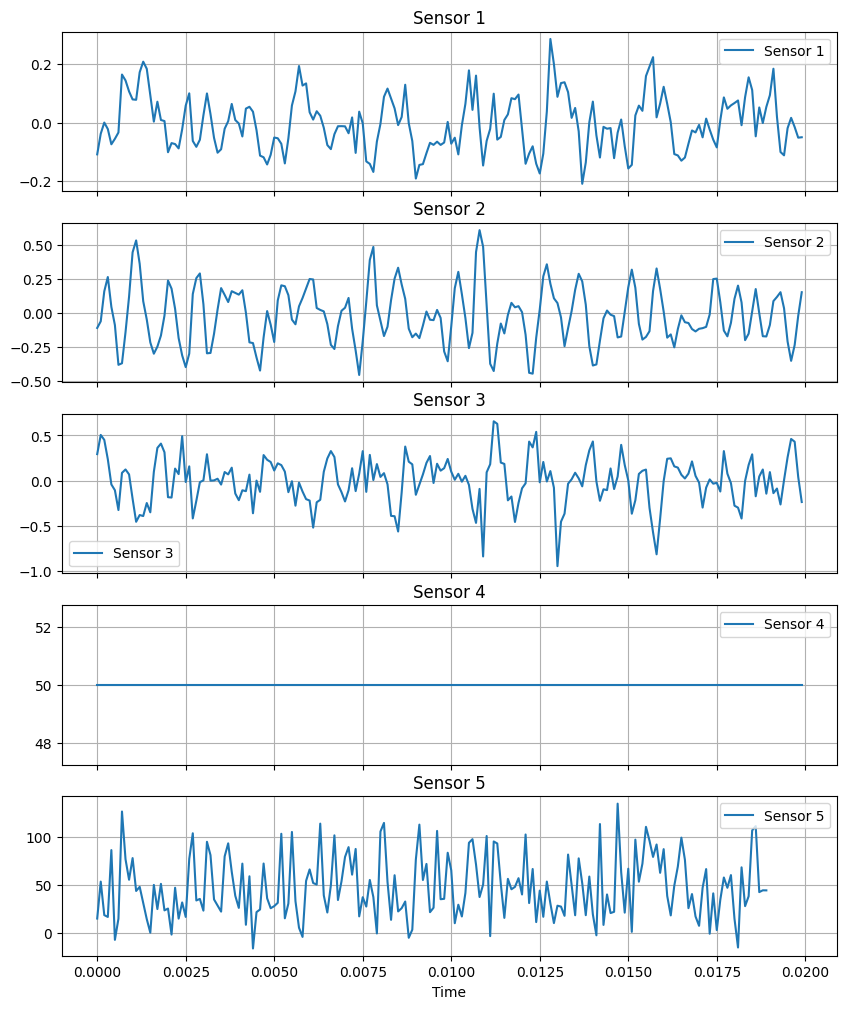

In [17]:

sample_set = 1000
sample_array = [data1[sample_set], data2[sample_set], data3[sample_set], data4[sample_set], data5[sample_set]]
fs = 10000
fig, axs = plt.subplots(5,1, figsize=(10,12), sharex=True)

for idx, sensor in enumerate(sample_array):
    if np.isnan(sensor).any():
        sensor = sensor[~np.isnan(sensor)]
    time = np.arange(len(sensor)) / fs
    axs[idx].plot(time, sensor, label=f"Sensor {idx + 1}")
    axs[idx].set_title(f"Sensor {idx + 1}")
    axs[idx].legend()
    axs[idx].grid(True)

plt.xlabel("Time")

# 5. **Pre-processing**

## **Data 1**

In [18]:
df1.head()

,0,1,2,3,4,5,6,7,8,9,...,191,192,193,194,195,196,197,198,199,200
0,-0.032906,-0.037456,-0.034082,-0.001968,0.084229,0.156574,0.128887,0.042514,-0.036834,-0.013936,...,-0.099786,-0.080654,-0.070954,-0.003636,0.012660,0.028986,0.008340,0.065012,0.091692,NaN
1,0.198619,0.178949,0.072092,0.083383,0.151363,0.108910,-0.099102,-0.195660,-0.125213,0.042914,...,-0.135897,-0.024512,0.103591,0.168580,0.032522,0.117073,0.001361,0.060746,0.093414,NaN
2,-0.000792,0.012913,0.017356,0.024251,0.022153,0.019270,0.017725,0.013644,0.015150,0.020608,...,0.016042,0.014681,0.017848,0.015588,0.011422,0.008025,0.009931,0.006395,0.002775,NaN
3,-0.086419,-0.112830,-0.124875,-0.029539,-0.067434,-0.077257,0.064067,0.075505,0.044812,-0.055143,...,-0.032053,0.002037,0.062153,-0.033044,-0.065966,-0.102277,-0.187535,-0.140448,-0.050016,NaN
4,-0.185975,-0.066973,0.042906,0.007640,-0.038686,-0.012729,0.111408,0.104206,0.040331,-0.042868,...,0.114014,0.089271,0.050639,-0.007533,-0.037725,0.003866,-0.020646,-0.089609,-0.127734,NaN


In [19]:
df1.describe()

,0,1,2,3,4,5,6,7,8,9,...,191,192,193,194,195,196,197,198,199,200
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,...,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,1.0
mean,0.007289,0.007187,0.007660,0.008018,0.008396,0.007812,0.006954,0.006113,0.006830,0.007849,...,0.007967,0.007985,0.007306,0.006202,0.006234,0.006831,0.008016,0.008111,0.008129,2.0
std,0.085314,0.085315,0.085607,0.085666,0.087407,0.086596,0.088514,0.085360,0.085222,0.085682,...,0.085730,0.085442,0.085686,0.085595,0.085583,0.085959,0.086225,0.085671,0.085294,NaN
min,-0.378568,-0.348952,-0.379936,-0.378360,-0.342088,-0.389444,-0.359782,-0.322280,-0.355839,-0.361581,...,-0.369974,-0.349106,-0.390344,-0.441082,-0.392542,-0.357499,-0.329713,-0.423119,-0.366331,2.0
25%,-0.049378,-0.049555,-0.048688,-0.048348,-0.048804,-0.048556,-0.050016,-0.050902,-0.050010,-0.049618,...,-0.049309,-0.048573,-0.050141,-0.050337,-0.050310,-0.050297,-0.049501,-0.048265,-0.048473,2.0
50%,0.006772,0.006710,0.007225,0.007587,0.007790,0.006814,0.006334,0.005773,0.006749,0.006956,...,0.007202,0.007414,0.006995,0.006042,0.005788,0.006468,0.007840,0.007567,0.007256,2.0
75%,0.063485,0.063567,0.064876,0.064693,0.065283,0.064269,0.063285,0.062706,0.063293,0.064836,...,0.064828,0.064830,0.064497,0.062584,0.062591,0.063859,0.065483,0.065059,0.064815,2.0
max,0.394856,1.000000,0.387984,0.422204,4.000000,3.000000,5.000000,0.397177,0.401343,0.399806,...,0.397707,0.394810,0.363095,0.428676,0.399029,0.431874,0.380536,0.381942,0.376908,2.0


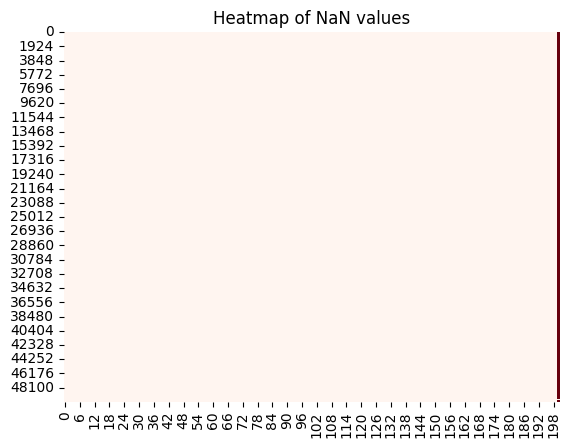

In [20]:
sns.heatmap(df1.isnull(), cbar=False, cmap="Reds")
plt.title("Heatmap of NaN values")
plt.show()

In [21]:
# To remove the last column
df1.drop(200, axis=1, inplace=True)

In [22]:
df1.describe()

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,...,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,0.007289,0.007187,0.007660,0.008018,0.008396,0.007812,0.006954,0.006113,0.006830,0.007849,...,0.007123,0.007967,0.007985,0.007306,0.006202,0.006234,0.006831,0.008016,0.008111,0.008129
std,0.085314,0.085315,0.085607,0.085666,0.087407,0.086596,0.088514,0.085360,0.085222,0.085682,...,0.085383,0.085730,0.085442,0.085686,0.085595,0.085583,0.085959,0.086225,0.085671,0.085294
min,-0.378568,-0.348952,-0.379936,-0.378360,-0.342088,-0.389444,-0.359782,-0.322280,-0.355839,-0.361581,...,-0.350720,-0.369974,-0.349106,-0.390344,-0.441082,-0.392542,-0.357499,-0.329713,-0.423119,-0.366331
25%,-0.049378,-0.049555,-0.048688,-0.048348,-0.048804,-0.048556,-0.050016,-0.050902,-0.050010,-0.049618,...,-0.050189,-0.049309,-0.048573,-0.050141,-0.050337,-0.050310,-0.050297,-0.049501,-0.048265,-0.048473
50%,0.006772,0.006710,0.007225,0.007587,0.007790,0.006814,0.006334,0.005773,0.006749,0.006956,...,0.006364,0.007202,0.007414,0.006995,0.006042,0.005788,0.006468,0.007840,0.007567,0.007256
75%,0.063485,0.063567,0.064876,0.064693,0.065283,0.064269,0.063285,0.062706,0.063293,0.064836,...,0.063698,0.064828,0.064830,0.064497,0.062584,0.062591,0.063859,0.065483,0.065059,0.064815
max,0.394856,1.000000,0.387984,0.422204,4.000000,3.000000,5.000000,0.397177,0.401343,0.399806,...,0.356731,0.397707,0.394810,0.363095,0.428676,0.399029,0.431874,0.380536,0.381942,0.376908


In [23]:
df1_feat = extract_features(df1)

In [24]:
df1_feat.head()

,mean,std,min,max,median
0,0.009764,0.096006,-0.223562,0.338075,0.009447
1,0.009800,0.099123,-0.306607,0.198619,0.022521
2,0.005349,0.010704,-0.020569,0.027556,0.006111
3,0.000187,0.085822,-0.209703,0.235776,-0.004547
4,0.006093,0.060326,-0.185975,0.170310,0.003251


## **Data 2**

In [25]:
df2.head()

,0,1,2,3,4,5,6,7,8,9,...,191,192,193,194,195,196,197,198,199,200
0,-0.032458,-0.065895,-0.033437,0.023354,-0.050963,-0.079567,-0.158764,-0.225719,-0.146064,-0.081333,...,0.010493,-0.093568,-0.100504,-0.034874,-0.048169,-0.142620,-0.188990,-0.142274,-0.018007,NaN
1,-0.044002,-0.026300,-0.142555,-0.158291,-0.053877,0.194706,0.371975,0.349063,0.101813,-0.060733,...,-0.349464,-0.163123,-0.196713,-0.080442,-0.181516,-0.205376,0.074509,0.403759,0.612137,NaN
2,0.012965,0.018673,0.022848,0.019043,0.014483,0.016875,0.020697,0.016353,0.012179,0.009473,...,-0.017541,0.012973,0.039707,0.041048,0.023619,-0.007386,-0.034698,-0.041762,-0.034946,NaN
3,-0.254154,-0.032329,0.128346,0.168663,0.076516,-0.087474,-0.226562,-0.246696,0.034384,0.222010,...,0.191382,-0.148071,-0.462669,-0.611037,-0.382227,-0.023563,0.282446,0.263467,0.048787,NaN
4,-0.134391,-0.047647,0.127326,0.190226,-0.003597,-0.089642,-0.076058,-0.071603,-0.012291,-0.035886,...,-0.000289,0.142941,0.081774,0.140243,0.106750,0.187425,0.092853,-0.178072,-0.215732,NaN


In [26]:
df2.describe()

,0,1,2,3,4,5,6,7,8,9,...,191,192,193,194,195,196,197,198,199,200
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,...,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,1.0
mean,0.007429,0.006079,0.005777,0.007024,0.008554,0.009425,0.009220,0.008332,0.006749,0.006704,...,0.006356,0.007168,0.008157,0.008812,0.008491,0.007969,0.008447,0.009178,0.008692,4.0
std,0.184788,0.185121,0.186277,0.185731,0.185365,0.185401,0.186190,0.185756,0.184938,0.185616,...,0.187311,0.185800,0.184736,0.184234,0.185569,0.186525,0.185257,0.185349,0.185220,NaN
min,-0.836852,-0.947977,-0.856497,-0.888746,-0.779579,-0.927522,-0.933543,-1.064409,-0.929456,-1.083725,...,-1.088036,-0.999823,-0.952023,-0.911602,-0.951774,-1.018087,-0.945962,-0.898243,-1.046209,4.0
25%,-0.110485,-0.112307,-0.113542,-0.112181,-0.109650,-0.108472,-0.108518,-0.110262,-0.111410,-0.111972,...,-0.112065,-0.111663,-0.109152,-0.109094,-0.109947,-0.111019,-0.110517,-0.109923,-0.110106,4.0
50%,0.005182,0.004965,0.004159,0.004933,0.006880,0.007418,0.007177,0.005608,0.004456,0.004945,...,0.005218,0.005784,0.006824,0.006427,0.006214,0.005596,0.006539,0.007161,0.006571,4.0
75%,0.125006,0.122995,0.124695,0.125979,0.126523,0.126995,0.127567,0.127063,0.123418,0.125614,...,0.124237,0.125720,0.125185,0.126710,0.126240,0.125401,0.124942,0.126383,0.125162,4.0
max,0.844976,1.009312,1.073818,0.945777,0.969276,0.947359,0.897111,0.842592,0.903180,0.913761,...,5.000000,0.954319,0.976894,0.934610,0.896822,3.000000,0.926960,0.936625,0.909563,4.0


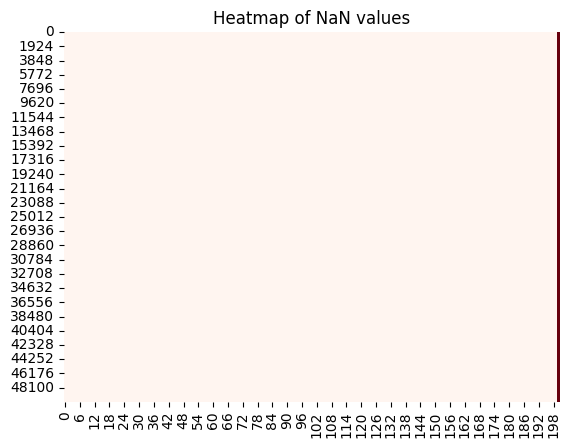

In [27]:
sns.heatmap(df2.isnull(), cbar=False, cmap="Reds")
plt.title("Heatmap of NaN values")
plt.show()

In [28]:
# To remove the last column
df2.drop(200, axis=1, inplace=True)

In [29]:
df2.describe()

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,...,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,0.007429,0.006079,0.005777,0.007024,0.008554,0.009425,0.009220,0.008332,0.006749,0.006704,...,0.006223,0.006356,0.007168,0.008157,0.008812,0.008491,0.007969,0.008447,0.009178,0.008692
std,0.184788,0.185121,0.186277,0.185731,0.185365,0.185401,0.186190,0.185756,0.184938,0.185616,...,0.184704,0.187311,0.185800,0.184736,0.184234,0.185569,0.186525,0.185257,0.185349,0.185220
min,-0.836852,-0.947977,-0.856497,-0.888746,-0.779579,-0.927522,-0.933543,-1.064409,-0.929456,-1.083725,...,-0.845241,-1.088036,-0.999823,-0.952023,-0.911602,-0.951774,-1.018087,-0.945962,-0.898243,-1.046209
25%,-0.110485,-0.112307,-0.113542,-0.112181,-0.109650,-0.108472,-0.108518,-0.110262,-0.111410,-0.111972,...,-0.112041,-0.112065,-0.111663,-0.109152,-0.109094,-0.109947,-0.111019,-0.110517,-0.109923,-0.110106
50%,0.005182,0.004965,0.004159,0.004933,0.006880,0.007418,0.007177,0.005608,0.004456,0.004945,...,0.004110,0.005218,0.005784,0.006824,0.006427,0.006214,0.005596,0.006539,0.007161,0.006571
75%,0.125006,0.122995,0.124695,0.125979,0.126523,0.126995,0.127567,0.127063,0.123418,0.125614,...,0.123691,0.124237,0.125720,0.125185,0.126710,0.126240,0.125401,0.124942,0.126383,0.125162
max,0.844976,1.009312,1.073818,0.945777,0.969276,0.947359,0.897111,0.842592,0.903180,0.913761,...,0.915367,5.000000,0.954319,0.976894,0.934610,0.896822,3.000000,0.926960,0.936625,0.909563


In [30]:
df2_feat = extract_features(df2)

In [31]:
df2_feat.head()

,mean,std,min,max,median
0,0.011494,0.162018,-0.406456,0.511311,0.006398
1,0.002345,0.212826,-0.626338,0.612137,-0.027251
2,0.011791,0.020647,-0.041762,0.056871,0.013262
3,-0.005966,0.197349,-0.611037,0.569074,-0.008767
4,0.002964,0.176177,-0.621738,0.660217,-0.001798


## **Data 3**

In [32]:
df3.head()

,0,1,2,3,4,5,6,7,8,9,...,191,192,193,194,195,196,197,198,199,200
0,-0.182078,-0.165990,0.147757,0.096662,-0.056907,-0.310580,-0.470552,-0.273967,-0.233207,0.225104,...,0.328633,0.500143,0.550680,0.321061,0.138348,-0.058564,-0.195702,-0.276894,-0.288260,NaN
1,-0.065122,-0.232418,-0.464595,-0.510616,-0.201496,-0.074505,-0.114415,0.194517,0.411912,0.521579,...,0.268816,0.749696,-0.057662,0.055156,-0.692248,-0.331509,-0.041532,0.076351,0.128364,NaN
2,-0.057997,-0.030175,-0.005425,0.009177,0.013701,-0.011606,-0.009907,-0.016371,0.001897,0.010207,...,-0.039403,-0.042588,-0.008130,0.013023,0.004155,-0.002979,-0.005700,0.000764,0.010061,NaN
3,-0.200595,0.315052,0.170669,0.268558,0.201994,-0.371161,-0.040613,-0.098962,0.364336,-0.112432,...,-0.091030,-0.055542,0.326169,0.212304,0.196199,0.237998,0.140512,-0.038527,0.052666,NaN
4,0.519974,0.341149,0.177562,0.133386,-0.224563,-0.336170,-0.318349,-0.283470,-0.142941,-0.067672,...,-0.092936,-0.172695,-0.195384,-0.185443,0.019908,0.100448,0.390107,0.020646,0.221575,NaN


In [33]:
df3.describe()

,0,1,2,3,4,5,6,7,8,9,...,191,192,193,194,195,196,197,198,199,200
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,...,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,1.0
mean,0.007364,0.007188,0.010472,0.010468,0.009880,0.009110,0.008085,0.008564,0.010404,0.011548,...,0.010350,0.011186,0.009841,0.010015,0.009473,0.010317,0.010272,0.009147,0.007458,2.0
std,0.234831,0.233902,0.235635,0.237471,0.236489,0.235360,0.235589,0.235230,0.235945,0.235738,...,0.234277,0.234980,0.234763,0.234777,0.236648,0.236568,0.234857,0.234904,0.237189,NaN
min,-1.160500,-1.287250,-1.409297,-1.120401,-1.234061,-1.117860,-1.202907,-1.293320,-1.145073,-1.319262,...,-1.102983,-1.149958,-1.189867,-1.166174,-1.433024,-1.345256,-1.198916,-1.245255,-1.328928,2.0
25%,-0.143990,-0.140879,-0.139374,-0.142344,-0.142503,-0.141739,-0.142342,-0.141838,-0.139243,-0.139698,...,-0.141216,-0.139211,-0.141510,-0.141559,-0.143252,-0.141353,-0.141415,-0.143578,-0.144892,2.0
50%,0.005297,0.005511,0.007936,0.008992,0.007657,0.007958,0.006923,0.008082,0.008881,0.009606,...,0.008546,0.009267,0.006932,0.008220,0.007554,0.008997,0.007954,0.007808,0.006048,2.0
75%,0.158464,0.156764,0.161966,0.162136,0.161074,0.160035,0.159292,0.160919,0.161413,0.162284,...,0.161175,0.159998,0.160544,0.161297,0.162490,0.161183,0.162540,0.160559,0.158880,2.0
max,1.245040,1.223124,1.259574,4.000000,1.223871,1.225897,1.118453,1.236507,1.493580,1.169479,...,1.291096,1.268673,1.382873,1.104898,1.129389,1.295929,1.170741,1.233872,1.297114,2.0


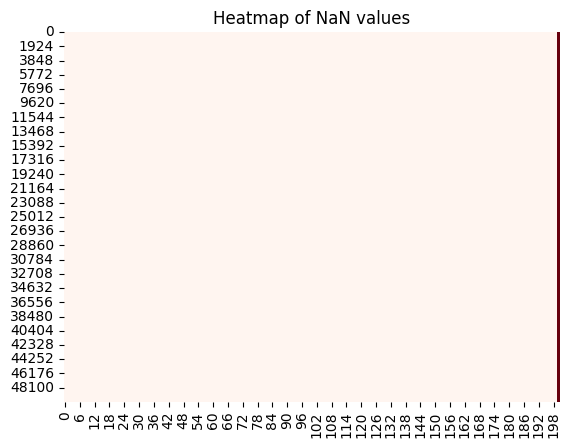

In [34]:
sns.heatmap(df3.isnull(), cbar=False, cmap="Reds")
plt.title("Heatmap of NaN values")
plt.show()

In [35]:
# To remove the last column
df3.drop(200, axis=1, inplace=True)

In [36]:
df3.describe()

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,...,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,0.007364,0.007188,0.010472,0.010468,0.009880,0.009110,0.008085,0.008564,0.010404,0.011548,...,0.009642,0.010350,0.011186,0.009841,0.010015,0.009473,0.010317,0.010272,0.009147,0.007458
std,0.234831,0.233902,0.235635,0.237471,0.236489,0.235360,0.235589,0.235230,0.235945,0.235738,...,0.236122,0.234277,0.234980,0.234763,0.234777,0.236648,0.236568,0.234857,0.234904,0.237189
min,-1.160500,-1.287250,-1.409297,-1.120401,-1.234061,-1.117860,-1.202907,-1.293320,-1.145073,-1.319262,...,-1.188803,-1.102983,-1.149958,-1.189867,-1.166174,-1.433024,-1.345256,-1.198916,-1.245255,-1.328928
25%,-0.143990,-0.140879,-0.139374,-0.142344,-0.142503,-0.141739,-0.142342,-0.141838,-0.139243,-0.139698,...,-0.141853,-0.141216,-0.139211,-0.141510,-0.141559,-0.143252,-0.141353,-0.141415,-0.143578,-0.144892
50%,0.005297,0.005511,0.007936,0.008992,0.007657,0.007958,0.006923,0.008082,0.008881,0.009606,...,0.008413,0.008546,0.009267,0.006932,0.008220,0.007554,0.008997,0.007954,0.007808,0.006048
75%,0.158464,0.156764,0.161966,0.162136,0.161074,0.160035,0.159292,0.160919,0.161413,0.162284,...,0.164087,0.161175,0.159998,0.160544,0.161297,0.162490,0.161183,0.162540,0.160559,0.158880
max,1.245040,1.223124,1.259574,4.000000,1.223871,1.225897,1.118453,1.236507,1.493580,1.169479,...,1.086742,1.291096,1.268673,1.382873,1.104898,1.129389,1.295929,1.170741,1.233872,1.297114


In [38]:
df3_feat = extract_features(df3)

In [39]:
df3_feat.head()

,mean,std,min,max,median
0,0.006821,0.284625,-0.916313,0.674950,0.028561
1,0.006794,0.276058,-0.733694,0.749696,0.022560
2,0.005558,0.023630,-0.057997,0.056572,0.005906
3,-0.001712,0.205710,-0.498778,0.463487,-0.008065
4,0.001560,0.192966,-0.564836,0.606119,-0.002743


## **Data 4**



In [40]:
df4.head()

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,...,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0
1,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,...,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0
2,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,...,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0
3,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,...,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0
4,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,...,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0


In [41]:
df4.describe()

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
count,49949.0,49932.0,49955.0,49940.0,49939.0,49959.0,49957.0,49952.0,49965.0,49961.0,...,49954.0,49945.0,49949.0,49951.0,49952.0,49941.0,49953.0,49946.0,49956.0,49959.0
mean,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,...,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,...,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0
25%,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,...,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0
50%,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,...,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0
75%,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,...,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0
max,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,...,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0


## **Data 5**

In [42]:
df5.head()

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,20.881372,15.145424,72.027388,48.214406,131.643082,41.718371,77.190388,132.137176,85.425556,48.097219,...,123.293161,56.924154,87.385904,3.348593,16.641810,3.697981,108.142391,17.575017,76.216150,29.315787
1,-1.206457,46.549414,46.111607,10.361296,27.363958,23.396119,30.862030,55.051419,63.062865,38.094601,...,27.373759,33.123615,49.853440,17.299022,40.767354,14.032730,131.006130,56.469465,78.645074,14.561567
2,62.824083,68.291606,40.739371,89.487447,85.516643,13.587243,91.161633,14.344760,18.180341,26.735392,...,51.169306,5.996007,21.488412,86.499347,27.132945,1.962554,9.571521,39.671621,47.163325,23.415191
3,-7.094894,51.408032,76.682650,5.085699,22.564127,76.027758,17.434208,3.158283,23.282799,22.444662,...,-4.630175,38.254381,96.444782,111.459248,51.875774,30.796453,-1.938128,19.691450,43.165328,67.912757
4,14.008962,95.614914,-11.578788,42.905703,49.074270,26.468865,32.333575,26.889737,106.665714,76.073738,...,106.132122,80.656916,109.780935,93.432256,88.455765,49.130590,41.568268,74.413566,12.231324,NaN


In [43]:
df5.describe()

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
count,48760.000000,48793.000000,48811.000000,48769.000000,48738.000000,48776.000000,48822.000000,48777.000000,48799.000000,48759.000000,...,48825.000000,48784.000000,48834.000000,48798.000000,48754.000000,48758.000000,48769.000000,48786.000000,48810.000000,48758.000000
mean,48.171903,48.226336,48.151227,48.175697,48.283013,47.980309,48.293169,48.358992,48.351152,48.358350,...,48.117208,48.530025,48.419275,48.164886,48.150535,48.250841,48.270815,48.290799,48.506421,48.725258
std,33.727605,33.772113,33.718041,33.614475,33.724703,33.685095,33.572119,33.720010,33.642793,33.583507,...,33.656421,33.654042,33.749817,33.624399,33.706828,33.698864,33.500802,33.626036,33.865765,33.858791
min,-19.449902,-19.947559,-19.423360,-19.424884,-19.771548,-19.613178,-19.607800,-19.438007,-19.655337,-19.669452,...,-19.331443,-19.357963,-19.603765,-19.634602,-19.381411,-19.552608,-19.693556,-19.686406,-19.533194,-19.616948
25%,22.309652,22.093855,22.182332,22.395859,22.508544,22.163776,22.621406,22.578589,22.623895,22.460733,...,22.206402,22.646801,22.409823,22.483294,22.271366,22.446330,22.555572,22.417031,22.594902,22.613827
50%,43.690278,44.044920,44.014742,44.220240,43.765324,43.720539,43.952475,43.962784,44.183044,44.121983,...,43.842214,44.180046,44.124261,43.681425,43.823449,43.965947,44.095170,44.125049,44.192684,44.720276
75%,71.905092,72.066100,72.026225,71.939241,71.936590,72.027689,72.030185,72.036972,72.069879,72.076460,...,71.917568,72.531487,72.380098,71.925099,71.800314,72.122544,71.886406,71.983987,72.542965,72.857939
max,139.510530,139.412802,139.741928,139.471412,139.594172,139.150733,139.508418,139.721778,139.495520,139.307064,...,139.674149,139.278859,139.475746,139.528672,139.458214,139.686525,139.056941,139.852067,139.764397,139.998311


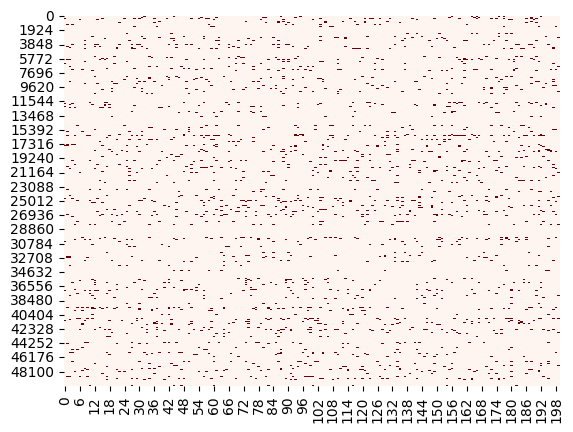

In [44]:
sns.heatmap(df5.isnull(), cbar=False, cmap="Reds")
# plt.title("Heatmap of NaN values")
plt.show()

In [45]:
# Check the proportion of NaNs per column
lines = len(df5)
proporcao_nan = df5.isnull().sum() / lines
resultado = proporcao_nan[proporcao_nan > 0].sort_values(ascending=False)

for i in resultado:
    if (i > 0.05):
        print("Mais de 5% de NaN")

In [46]:
# Here it is necessary to look in more depth at which approach to use.
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
df5 = pd.DataFrame(imputer.fit_transform(df5))

In [47]:
df5.describe()

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,...,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,48.171903,48.226336,48.151227,48.175697,48.283013,47.980309,48.293169,48.358992,48.351152,48.358350,...,48.117208,48.530025,48.419275,48.164886,48.150535,48.250841,48.270815,48.290799,48.506421,48.725258
std,33.306749,33.361985,33.314713,33.198094,33.296369,33.270226,33.174274,33.305052,33.236279,33.164108,...,33.258599,33.242281,33.353965,33.217767,33.284183,33.277684,33.085829,33.215299,33.460328,33.435612
min,-19.449902,-19.947559,-19.423360,-19.424884,-19.771548,-19.613178,-19.607800,-19.438007,-19.655337,-19.669452,...,-19.331443,-19.357963,-19.603765,-19.634602,-19.381411,-19.552608,-19.693556,-19.686406,-19.533194,-19.616948
25%,22.807356,22.632563,22.676368,22.915698,23.073457,22.698099,23.146179,23.113295,23.152213,22.958357,...,22.727408,23.174372,22.925973,23.028035,22.785281,22.986157,23.103935,22.931747,23.076038,23.167452
50%,44.939465,45.237563,45.202153,45.353647,45.013177,44.995755,45.108774,45.213186,45.351459,45.304337,...,44.948653,45.323570,45.306352,44.860305,45.093043,45.224257,45.279543,45.303903,45.324145,45.941724
75%,71.035149,71.194199,71.227979,71.089790,70.991959,71.167969,71.238096,71.266247,71.179964,71.288049,...,71.139897,71.674735,71.581876,71.121471,70.992174,71.197910,71.086275,71.073107,71.762001,72.035849
max,139.510530,139.412802,139.741928,139.471412,139.594172,139.150733,139.508418,139.721778,139.495520,139.307064,...,139.674149,139.278859,139.475746,139.528672,139.458214,139.686525,139.056941,139.852067,139.764397,139.998311


In [48]:
df5_feat = extract_features(df5)

In [49]:
df5_feat.head()

,mean,std,min,max,median
0,46.081684,34.189453,-12.651880,135.600877,44.230629
1,52.770691,32.630078,-9.004100,135.852685,48.292261
2,48.978503,33.410942,-15.750924,122.769849,44.501977
3,43.456594,33.387024,-18.253981,126.599329,38.245346
4,51.788923,34.302792,-15.093023,135.558167,48.121066


# 6.1 **Features{Mean, STD, min, max, median}**


In [50]:
def rename_sensor_columns(df, sensor_id):
    return df.rename(columns=lambda col: f'sensor{sensor_id}_{col}')
df1_ren = rename_sensor_columns(df1_feat, 1)
df2_ren = rename_sensor_columns(df2_feat, 2)
df3_ren = rename_sensor_columns(df3_feat, 3)
# Sensor 4 was removed Because it doesn't add information to the models
df4_ren = rename_sensor_columns(df5_feat, 4) # Sensor 5 is now index 4

In [51]:
df_sens = pd.concat(
    [df1_ren, df2_ren, df3_ren, df4_ren],
    axis=1
)

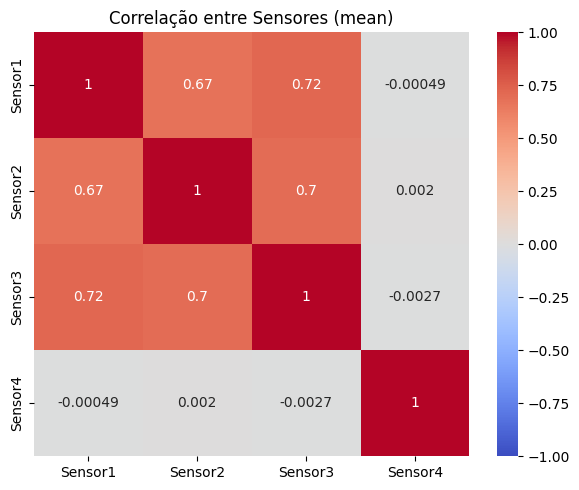

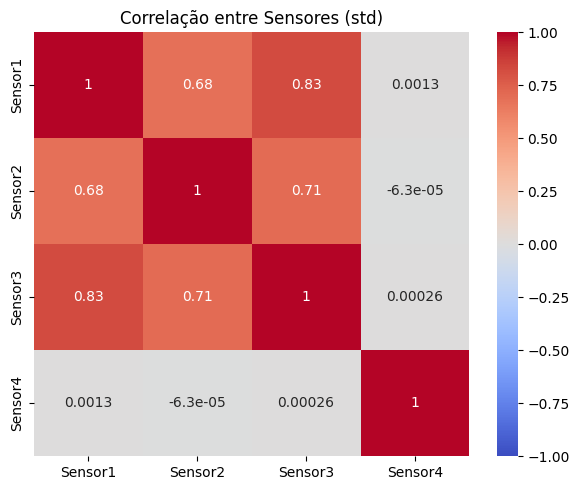

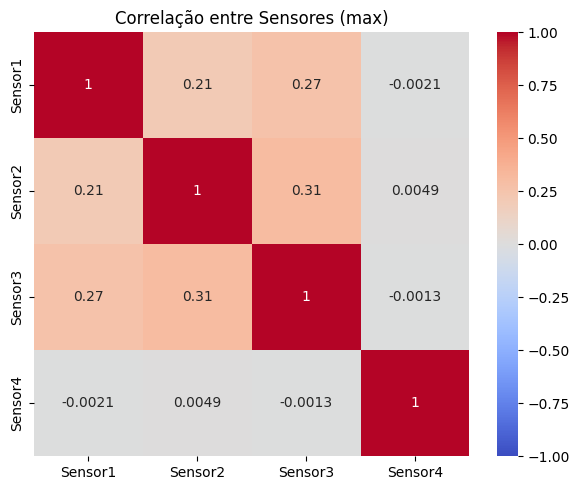

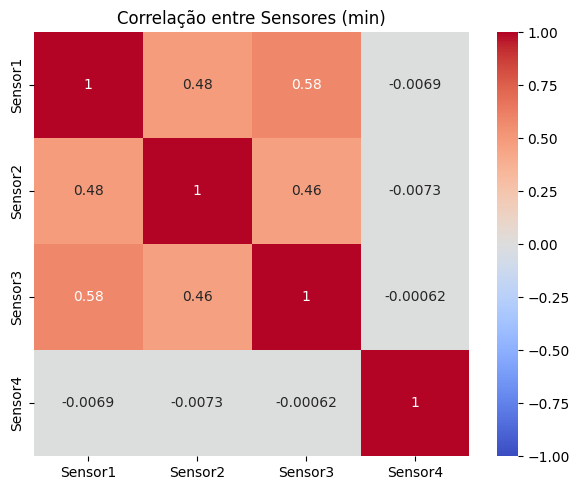

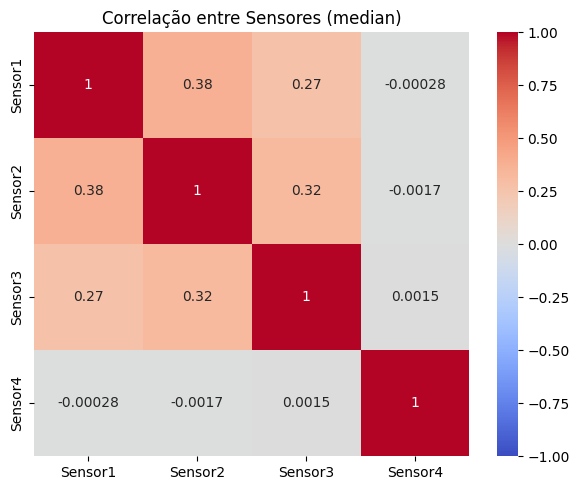

In [52]:
df_list = [df1_ren, df2_ren, df3_ren, df4_ren]
features = ['mean', 'std', 'max', 'min', 'median']

plot_feature_correlations(df_list, features)

In [53]:
final_df = pd.concat([df_sens, label_df], axis=1)

In [54]:
final_df.head()

,sensor1_mean,sensor1_std,sensor1_min,sensor1_max,sensor1_median,sensor2_mean,sensor2_std,sensor2_min,sensor2_max,sensor2_median,...,sensor3_std,sensor3_min,sensor3_max,sensor3_median,sensor4_mean,sensor4_std,sensor4_min,sensor4_max,sensor4_median,label
0,0.009764,0.096006,-0.223562,0.338075,0.009447,0.011494,0.162018,-0.406456,0.511311,0.006398,...,0.284625,-0.916313,0.674950,0.028561,46.081684,34.189453,-12.651880,135.600877,44.230629,3
1,0.009800,0.099123,-0.306607,0.198619,0.022521,0.002345,0.212826,-0.626338,0.612137,-0.027251,...,0.276058,-0.733694,0.749696,0.022560,52.770691,32.630078,-9.004100,135.852685,48.292261,0
2,0.005349,0.010704,-0.020569,0.027556,0.006111,0.011791,0.020647,-0.041762,0.056871,0.013262,...,0.023630,-0.057997,0.056572,0.005906,48.978503,33.410942,-15.750924,122.769849,44.501977,0
3,0.000187,0.085822,-0.209703,0.235776,-0.004547,-0.005966,0.197349,-0.611037,0.569074,-0.008767,...,0.205710,-0.498778,0.463487,-0.008065,43.456594,33.387024,-18.253981,126.599329,38.245346,1
4,0.006093,0.060326,-0.185975,0.170310,0.003251,0.002964,0.176177,-0.621738,0.660217,-0.001798,...,0.192966,-0.564836,0.606119,-0.002743,51.788923,34.302792,-15.093023,135.558167,48.121066,3


In [55]:
# Separate features and labels
X = final_df.drop(columns=['label'])
y = final_df['label']

In [56]:
# Training/testing division
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=1
)

In [57]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(35000, 20)
(15000, 20)
(35000,)
(15000,)


## 6.1 *Random Forest*

In [277]:
param = {'criterion': ['gini', 'entropy'],
        'n_estimators': [10, 40, 100, 150],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 5, 10]}

In [284]:
# Exhaustive search over specified parameter values for an estimator.
grid_search = GridSearchCV(estimator=RandomForestClassifier(), cv=2, param_grid=param, scoring='f1_macro', verbose=10)
grid_search.fit(X_train, y_train)
best_param = grid_search.best_params_
best_result = grid_search.best_score_
print(best_param)
print(best_result)

Fitting 2 folds for each of 72 candidates, totalling 144 fits
[CV 1/2; 1/72] START criterion=gini, min_samples_leaf=1, min_samples_split=2, n_estimators=10
[CV 1/2; 1/72] END criterion=gini, min_samples_leaf=1, min_samples_split=2, n_estimators=10;, score=0.393 total time=   1.0s
[CV 2/2; 1/72] START criterion=gini, min_samples_leaf=1, min_samples_split=2, n_estimators=10
[CV 2/2; 1/72] END criterion=gini, min_samples_leaf=1, min_samples_split=2, n_estimators=10;, score=0.389 total time=   0.8s
[CV 1/2; 2/72] START criterion=gini, min_samples_leaf=1, min_samples_split=2, n_estimators=40
[CV 1/2; 2/72] END criterion=gini, min_samples_leaf=1, min_samples_split=2, n_estimators=40;, score=0.441 total time=   3.1s
[CV 2/2; 2/72] START criterion=gini, min_samples_leaf=1, min_samples_split=2, n_estimators=40
[CV 2/2; 2/72] END criterion=gini, min_samples_leaf=1, min_samples_split=2, n_estimators=40;, score=0.442 total time=   3.1s
[CV 1/2; 3/72] START criterion=gini, min_samples_leaf=1, min_s

In [76]:
random_forest = RandomForestClassifier(criterion = 'entropy', min_samples_leaf = 5, min_samples_split=2, n_estimators = 150, random_state=1)
random_forest.fit(X_train, y_train)

,n_estimators,150
,criterion,'entropy'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,5
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


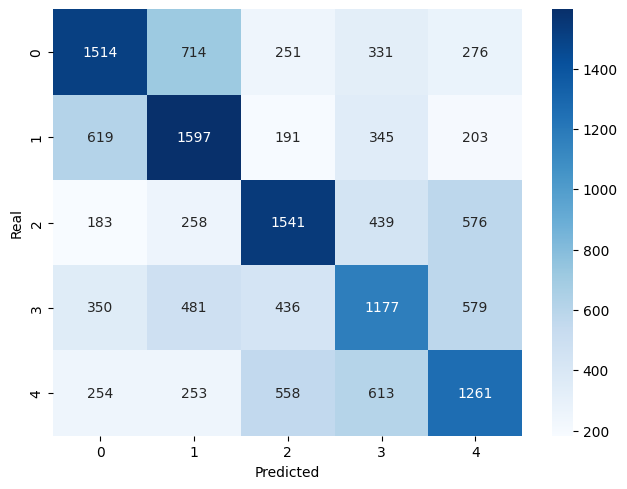

              precision    recall  f1-score   support

           0       0.52      0.49      0.50      3086
           1       0.48      0.54      0.51      2955
           2       0.52      0.51      0.52      2997
           3       0.41      0.39      0.40      3023
           4       0.44      0.43      0.43      2939

    accuracy                           0.47     15000
   macro avg       0.47      0.47      0.47     15000
weighted avg       0.47      0.47      0.47     15000



In [77]:
y_pred = random_forest.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.tight_layout()
plt.ylabel("Real")
plt.xlabel("Predicted")
plt.show()

print(classification_report(y_test, y_pred))

## 6.2 *SVM*

In [73]:
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train))
X_test_scaled = pd.DataFrame(scaler.fit_transform(X_test))

In [74]:
pca = PCA(n_components=0.95, random_state=1)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print(f" PCA reduced from {X_train_scaled.shape[1]} to {X_train_pca.shape[1]} components")

 PCA reduced from 20 to 14 components


In [75]:
param = {'tol': [0.001, 0.0001, 0.00001],
          'C': [1.0, 1.5, 2.0],
          'kernel': ['rbf', 'linear', 'poly', 'sigmoid']}

In [ ]:
grid_search = GridSearchCV(estimator=SVC(), param_grid=param, cv=2, verbose=10)
grid_search.fit(X_train_pca, y_train)
best_param = grid_search.best_params_
best_result = grid_search.best_score_

Fitting 2 folds for each of 36 candidates, totalling 72 fits
[CV 1/2; 1/36] START C=1.0, kernel=rbf, tol=0.001...............................
[CV 1/2; 1/36] END C=1.0, kernel=rbf, tol=0.001;, score=0.420 total time=  20.5s
[CV 2/2; 1/36] START C=1.0, kernel=rbf, tol=0.001...............................
[CV 2/2; 1/36] END C=1.0, kernel=rbf, tol=0.001;, score=0.423 total time=  20.8s
[CV 1/2; 2/36] START C=1.0, kernel=rbf, tol=0.0001..............................
[CV 1/2; 2/36] END C=1.0, kernel=rbf, tol=0.0001;, score=0.420 total time=  20.8s
[CV 2/2; 2/36] START C=1.0, kernel=rbf, tol=0.0001..............................
[CV 2/2; 2/36] END C=1.0, kernel=rbf, tol=0.0001;, score=0.423 total time=  21.1s
[CV 1/2; 3/36] START C=1.0, kernel=rbf, tol=1e-05...............................
[CV 1/2; 3/36] END C=1.0, kernel=rbf, tol=1e-05;, score=0.420 total time=  20.7s
[CV 2/2; 3/36] START C=1.0, kernel=rbf, tol=1e-05...............................
[CV 2/2; 3/36] END C=1.0, kernel=rbf, tol=1e-0

NameError: name 'melhores_parametros' is not defined

In [309]:
print(best_param)
print(best_result)

{'C': 2.0, 'kernel': 'rbf', 'tol': 0.0001}
0.4225714285714286


In [81]:
svm = SVC(kernel='rbf', C= 2.0, tol= 0.0001, random_state=1)
svm.fit(X_train_pca, y_train)

,C,2.0
,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.0001
,cache_size,200
,class_weight,None
,verbose,False


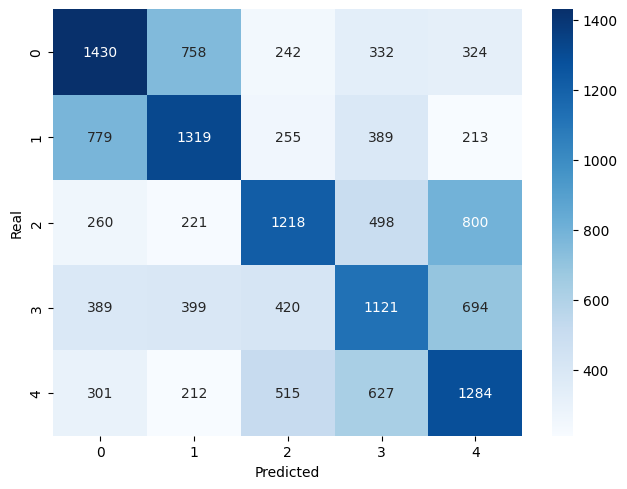

              precision    recall  f1-score   support

           0       0.45      0.46      0.46      3086
           1       0.45      0.45      0.45      2955
           2       0.46      0.41      0.43      2997
           3       0.38      0.37      0.37      3023
           4       0.39      0.44      0.41      2939

    accuracy                           0.42     15000
   macro avg       0.43      0.42      0.42     15000
weighted avg       0.43      0.42      0.42     15000



In [82]:
y_pred = svm.predict(X_test_pca)
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.tight_layout()
plt.ylabel("Real")
plt.xlabel("Predicted")
plt.show()

print(classification_report(y_test, y_pred))

# 7 **Complete Features**

In [83]:
def rename_sensor_columns(df, sensor_id):
    return df.rename(columns=lambda x: f'sensor{sensor_id}_f{x+1}')
df1 = rename_sensor_columns(df1, 1)
df2 = rename_sensor_columns(df2, 2)
df3 = rename_sensor_columns(df3, 3)
# Sensor 4 was removed Because it doesn't add information to the models
df4 = rename_sensor_columns(df5, 4) # Sensor 5 is now index 4

In [85]:
df_sens_com = pd.concat(
    [df1, df2, df3, df4],
    axis=1
)

In [86]:
df_sens_com.describe()

,sensor1_f1,sensor1_f2,sensor1_f3,sensor1_f4,sensor1_f5,sensor1_f6,sensor1_f7,sensor1_f8,sensor1_f9,sensor1_f10,...,sensor4_f191,sensor4_f192,sensor4_f193,sensor4_f194,sensor4_f195,sensor4_f196,sensor4_f197,sensor4_f198,sensor4_f199,sensor4_f200
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,...,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,0.007289,0.007187,0.007660,0.008018,0.008396,0.007812,0.006954,0.006113,0.006830,0.007849,...,48.117208,48.530025,48.419275,48.164886,48.150535,48.250841,48.270815,48.290799,48.506421,48.725258
std,0.085314,0.085315,0.085607,0.085666,0.087407,0.086596,0.088514,0.085360,0.085222,0.085682,...,33.258599,33.242281,33.353965,33.217767,33.284183,33.277684,33.085829,33.215299,33.460328,33.435612
min,-0.378568,-0.348952,-0.379936,-0.378360,-0.342088,-0.389444,-0.359782,-0.322280,-0.355839,-0.361581,...,-19.331443,-19.357963,-19.603765,-19.634602,-19.381411,-19.552608,-19.693556,-19.686406,-19.533194,-19.616948
25%,-0.049378,-0.049555,-0.048688,-0.048348,-0.048804,-0.048556,-0.050016,-0.050902,-0.050010,-0.049618,...,22.727408,23.174372,22.925973,23.028035,22.785281,22.986157,23.103935,22.931747,23.076038,23.167452
50%,0.006772,0.006710,0.007225,0.007587,0.007790,0.006814,0.006334,0.005773,0.006749,0.006956,...,44.948653,45.323570,45.306352,44.860305,45.093043,45.224257,45.279543,45.303903,45.324145,45.941724
75%,0.063485,0.063567,0.064876,0.064693,0.065283,0.064269,0.063285,0.062706,0.063293,0.064836,...,71.139897,71.674735,71.581876,71.121471,70.992174,71.197910,71.086275,71.073107,71.762001,72.035849
max,0.394856,1.000000,0.387984,0.422204,4.000000,3.000000,5.000000,0.397177,0.401343,0.399806,...,139.674149,139.278859,139.475746,139.528672,139.458214,139.686525,139.056941,139.852067,139.764397,139.998311


In [87]:
final_df_com = pd.concat([df_sens_com, label_df], axis=1)

In [88]:
final_df_com.head()

,sensor1_f1,sensor1_f2,sensor1_f3,sensor1_f4,sensor1_f5,sensor1_f6,sensor1_f7,sensor1_f8,sensor1_f9,sensor1_f10,...,sensor4_f192,sensor4_f193,sensor4_f194,sensor4_f195,sensor4_f196,sensor4_f197,sensor4_f198,sensor4_f199,sensor4_f200,label
0,-0.032906,-0.037456,-0.034082,-0.001968,0.084229,0.156574,0.128887,0.042514,-0.036834,-0.013936,...,56.924154,87.385904,3.348593,16.641810,3.697981,108.142391,17.575017,76.216150,29.315787,3
1,0.198619,0.178949,0.072092,0.083383,0.151363,0.108910,-0.099102,-0.195660,-0.125213,0.042914,...,33.123615,49.853440,17.299022,40.767354,14.032730,131.006130,56.469465,78.645074,14.561567,0
2,-0.000792,0.012913,0.017356,0.024251,0.022153,0.019270,0.017725,0.013644,0.015150,0.020608,...,5.996007,21.488412,86.499347,27.132945,1.962554,9.571521,39.671621,47.163325,23.415191,0
3,-0.086419,-0.112830,-0.124875,-0.029539,-0.067434,-0.077257,0.064067,0.075505,0.044812,-0.055143,...,38.254381,96.444782,111.459248,51.875774,30.796453,-1.938128,19.691450,43.165328,67.912757,1
4,-0.185975,-0.066973,0.042906,0.007640,-0.038686,-0.012729,0.111408,0.104206,0.040331,-0.042868,...,80.656916,109.780935,93.432256,88.455765,49.130590,41.568268,74.413566,12.231324,48.725258,3


In [89]:
X_com = final_df_com.drop(columns=['label'])
y_com = final_df_com['label']

In [90]:
X_train_com, X_test_com, y_train_com, y_test_com = train_test_split(
    X_com, y_com, test_size=0.2, random_state=1
)

In [91]:
print(X_train_com.shape)
print(X_test_com.shape)
print(y_train_com.shape)
print(y_test_com.shape)

(40000, 800)
(10000, 800)
(40000,)
(10000,)


## 7.1 Random Forest

In [92]:
random_forest = RandomForestClassifier(criterion = 'entropy', min_samples_leaf = 5, min_samples_split=2, n_estimators = 150, random_state=1)
random_forest.fit(X_train_com, y_train_com)

,n_estimators,150
,criterion,'entropy'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,5
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


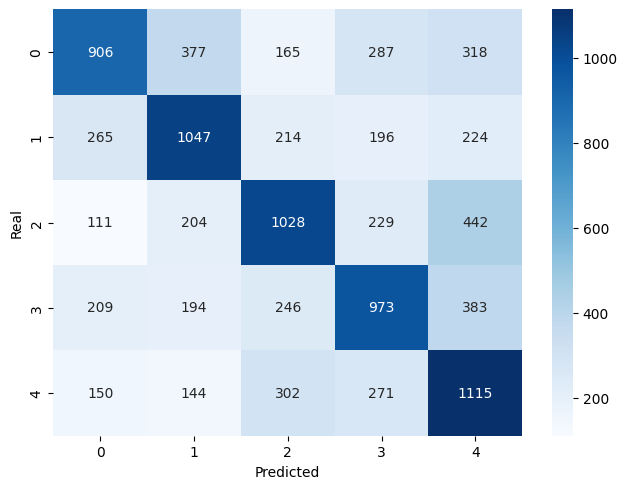

              precision    recall  f1-score   support

           0       0.55      0.44      0.49      2053
           1       0.53      0.54      0.54      1946
           2       0.53      0.51      0.52      2014
           3       0.50      0.49      0.49      2005
           4       0.45      0.56      0.50      1982

    accuracy                           0.51     10000
   macro avg       0.51      0.51      0.51     10000
weighted avg       0.51      0.51      0.51     10000



In [94]:
y_pred = random_forest.predict(X_test_com)
cm = confusion_matrix(y_test_com, y_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.tight_layout()
plt.ylabel("Real")
plt.xlabel("Predicted")
plt.show()

print(classification_report(y_test_com, y_pred))